In [13]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
from func import get_model2, get_model, get_data_loaders, get_patient_loader, MyNet, MyNet2
from torchvision import models
import os
import scipy

24


In [7]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
batch_size = 64
data_dir = "./data/"
criterion = torch.nn.CrossEntropyLoss()
#model = get_model()
model = MyNet(models.resnet50(weights="IMAGENET1K_V2"))
#model = MyNet(my_pretrained_model=models.resnet50(weights="IMAGENET1K_V2"))#path = "./data/05072024_single__5e-06resnet2.pt"
path = "./data/09072024_lr__0.0005resnet.pt"
model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))

patients = [os.path.basename(f) for f in os.scandir(data_dir) if f.is_dir()]

NameError: name 'MyNet' is not defined

In [19]:
def generate_results(model, device, criterion, data_dir, patient=None, gene = "RUBCNL", results_filename = "results.csv"):
    model.eval()
    print("generating results...")
    loader = get_patient_loader(data_dir, patient=patient, gene=gene)
    filename = data_dir + patient + "/Preprocessed_STDataset/" + results_filename
    print(filename)
    if os.path.exists(filename):
        os.remove(filename)
    columns = ['labels', 'output', 'path', 'tile']
    df = pd.DataFrame(columns=columns)
    df.to_csv(filename, index=False)
    i = 0
    j = len(loader)
    with torch.no_grad():
        for images, labels, name in loader:
            if i%1000==0:
                print(i, "/", j)
            i+=1
            images = images.unsqueeze(0).to(device)
            images = images.float()
            #labels = torch.stack(labels, dim=1)
            #labels = labels.float()
            labels = torch.tensor(labels[0]).to(device)
            
            output = model(images)
            
            output=output.squeeze().unsqueeze(0)
            labels=labels.unsqueeze(0)
            
            loss = criterion(output, labels).cpu()
            
            output = pd.DataFrame(output.cpu())
            labels = pd.DataFrame(labels.cpu())
            
            res = pd.concat([labels, output, pd.Series(name), pd.Series(os.path.basename(name))], axis=1)
            res.columns = columns
            
            res.to_csv(filename, index=False, mode='a', header=False)

def merge_data(data_dir, patient, results_filename = "results.csv"):
    
    if patient == 'p008':
        return
    base_path = data_dir+patient+"/Preprocessed_STDataset/"
    spatial_matrix = pd.read_csv(base_path + "spatial_data.csv")
    results  = pd.read_csv(base_path + results_filename)
    results = results.drop("path", axis=1)
#Merge spatial with test dataset to get spatial coordinates for predicted tiles
    merge = pd.merge(results, spatial_matrix, on = "tile")
    merge.set_index("tile", inplace=True)
    merge.to_csv(base_path + "merge.csv")
    
# function that combines all tiles back to the image
def plot_data_mapped(data_dir, patient, category = "diff"):
    base_path = data_dir+patient+"/Preprocessed_STDataset/"
    merge = pd.read_csv(base_path + "merge.csv")
    merge["diff"] = merge["labels"] - merge["output"]
    merge.to_csv(base_path + "merge.csv")
    plt.scatter(merge['x'], merge['y'], c=merge[category], cmap='viridis')
    plt.colorbar(label='labels')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(category + " for patient " + patient)
    plt.show()
    #merge.plot.scatter(x="x", y="y")
    
def plot_hist_comparison(data_dir, patient):
    base_path = data_dir+patient+"/Preprocessed_STDataset/"
    merge = pd.read_csv(base_path + "merge.csv")
    out = merge['output']
    plt.hist(out)
    plt.show()
    labels = merge['labels']
    plt.hist(labels)
    plt.show()
    
    
def print_metrics(data_dir, patient, metric):
    base_path = data_dir+patient+"/Preprocessed_STDataset/"
    merge = pd.read_csv(base_path + "merge.csv")
    out = merge['output']
    labels = merge['labels']
    mean_out = out.mean()
    std_out = out.std()
    mean_labels = labels.mean()
    std_labels = labels.std()
    if metric == "mean":
        print("mean diff: ", "{:.4f}".format(abs(mean_out-mean_labels)), ", mean out: ", "{:.4f}".format(mean_out), ", mean labels: ", "{:.4f}".format(mean_labels))
    if metric == "std":
        print("std diff: ", "{:.4f}".format(abs(std_out-std_labels)), ", std out: ", "{:.4f}".format(std_out), ", std labels: ", "{:.4f}".format(std_labels))

def plot_hist_comparison(data_dir, patient):
    base_path = data_dir+patient+"/Preprocessed_STDataset/"
    merge = pd.read_csv(base_path + "merge.csv")
    out = merge['output']
    plt.hist(out)
    plt.show()
    labels = merge['labels']
    plt.hist(labels)
    plt.show()
    
    
def print_metrics(data_dir, patient, metric):
    base_path = data_dir+patient+"/Preprocessed_STDataset/"
    merge = pd.read_csv(base_path + "merge.csv")
    out = merge['output']
    labels = merge['labels']
    mean_out = out.mean()
    std_out = out.std()
    mean_labels = labels.mean()
    std_labels = labels.std()
    if metric == "mean":
        print("mean diff: ", "{:.4f}".format(abs(mean_out-mean_labels)), ", mean out: ", "{:.4f}".format(mean_out), ", mean labels: ", "{:.4f}".format(mean_labels))
    if metric == "std":
        print("std diff: ", "{:.4f}".format(abs(std_out-std_labels)), ", std out: ", "{:.4f}".format(std_out), ", std labels: ", "{:.4f}".format(std_labels))
    if metric == "pearson":
        print("pearson corr: " + str(round(scipy.stats.pearsonr(out, labels)[0], 2)))
    
    
    
def plot_data_scatter(data_dir, patient, gene):
    base_path = data_dir+patient+"/Preprocessed_STDataset/"
    merge = pd.read_csv(base_path + "merge.csv")
    plt.scatter(merge['output'], merge['labels'])
    plt.text(x=-2, y=3 , s="pearson corr: " + str(round(scipy.stats.pearsonr(merge['output'], merge['labels'])[0], 2)))
    plt.plot( [-2,3],[-2,3], color='red' )
    plt.title("labels vs output for " + patient + " for gene " + gene)
    plt.xlabel('output')
    plt.ylabel('target')
    plt.show()
    
    
def process_and_plot_patient(model, device, criterion, data_dir, patient, gene = "RUBCNL", results_filename = "results.csv"):
    generate_results(model, device, criterion, data_dir, patient, gene, results_filename)
    merge_data(data_dir, patient, results_filename)
    plot_data_mapped(data_dir, patient, "labels")
    plot_data_mapped(data_dir, patient, "output")
    plot_data_mapped(data_dir, patient, "diff")
    plot_data_scatter(data_dir, patient, gene)
    print_metrics(data_dir, patient, "mean")
    print_metrics(data_dir, patient, "std")
    print_metrics(data_dir, patient, "pearson")
    
    print("----------------------------------------")

In [ ]:
models_per_epoch_dir = "./RUBCNL_HLR_old_model/"

models_per_epoch = [os.path.basename(f) for f in os.scandir(models_per_epoch_dir)]
#models_per_epoch = [f for f in os.scandir(models_per_epoch_dir)]
m = models_per_epoch[0]

model = MyNet(models.resnet50(weights="IMAGENET1K_V2"))
model.load_state_dict(torch.load(models_per_epoch_dir + m, map_location=torch.device(device)))
process_and_plot_patient(model.to(device), device, criterion, data_dir, "p007", "RUBCNL", results_filename = "slim_model_results.csv")

In [ ]:
process_and_plot_patient(old_model.to(device), device, criterion, data_dir, "p007", "RUBCNL", results_filename = "slim_model_results.csv")

In [ ]:
import os
patients = [os.path.basename(f) for f in os.scandir(data_dir) if f.is_dir()]
patients = patients[0:-1]#drop p008
print(patients)
for patient in patients:
    generate_results(model.to(device), device, criterion, data_dir, patient, "RUBCNL", "results_slim_model.csv")

In [ ]:
#------------------------------------------------------------------------------
def pearson_calc(test_df, true, preds, params):
  for j in range(len(true)):
    pearson_name = true[j].replace("true", "pearson")
    pearson_name = pearson_name + "_"+str(params[1])+"_"+params[2]+"_"+sample
    pearson = stats.pearsonr(test_df[true[j]], test_df[preds[j]])
    with open(test_log, "a") as f:
      f.write(pearson_name + ": " + ("%.4f" % pearson[0]))
      f.write("\n")
      f.write("-----------------------------------")
      f.write("\n")
    pearson_save_name = data_dir + date + "_ST_Predict_absolute_single_"+str(params[1])+"_" + params[2] +"_" + gene_list[0]+ params[0] + "pearson.pkl"
    with open(pearson_save_name, 'wb') as f: 
      pickle.dump([pearson], f)
#------------------------------------------------------------------------------

In [ ]:
def calc_residuals(test_df, true, preds):
  for i in range(len(true)):
    test_df[true[i]] = test_df[true[i]].astype(float)
    test_df[preds[i]] = test_df[preds[i]].astype(float)
    res_name = true[i].replace("true", "residuals")
    res_abs_name = true[i].replace("true", "residuals_abs")
    test_df[res_name] = test_df[true[i]] - test_df[preds[i]]
    test_df[res_abs_name] = test_df[res_name].abs()
  return test_df

In [ ]:
import os
data_dir = "./data/"
patients = [os.path.basename(f) for f in os.scandir(data_dir) if f.is_dir()]
patients = patients[0:-1]
print(patients)
for patient in patients:
    if patient == 'p008':
        continue
    filename = data_dir + "/" + patient + "/Preprocessed_STDataset/spatial_data.csv"
    spatial_matrix = pd.read_csv(data_dir+patient+"/Preprocessed_STDataset/Raw_Spatial_Matrix_156_"+patient+".csv") #adapt to sample
    spatial_matrix['tile'] = spatial_matrix['tile'].apply(lambda x: "{}{}".format(x, ".tiff"))
    spatial_matrix['tile'] = spatial_matrix['tile'].apply(lambda x: "{}{}".format(data_dir+patient+"/Tiles_156/", x[57:])) #adapt to sample
    spatial_matrix['path'] = spatial_matrix['tile']
    spatial_matrix['tile'] = spatial_matrix['tile'].apply(lambda x: os.path.basename(x))
    spatial_matrix.to_csv(filename, index=False)

In [ ]:

for patient in patients:
    merge_data(data_dir, patient, "results_slim_model.csv")

In [ ]:

    
print(patients)
for patient in patients:
    
    if patient == 'p008':
        continue
    plot_data_mapped(data_dir, patient, "labels")
    plot_data_mapped(data_dir, patient, "output")
    plot_data_mapped(data_dir, patient, "diff")
    print("----------------------------------------")

In [ ]:
# function that combines all tiles back to the image

    #merge.plot.scatter(x="x", y="y")
for patient in patients:
    
    
    if patient == 'p008':
        continue
    plot_data_scatter(data_dir, patient)

In [ ]:

for patient in patients:
    
    if patient == 'p008':
        continue
    print_metrics(data_dir, patient, "mean")
for patient in patients:
    
    if patient == 'p008':
        continue
    print_metrics(data_dir, patient, "std")
    

In [ ]:
from scipy import stats


In [ ]:
for patient in patients:
    base_path = data_dir+patient+"/Preprocessed_STDataset/"
    merge = pd.read_csv(base_path + "merge.csv")
    corr = stats.pearsonr(merge['output'], merge['labels'])
    print(corr)

In [ ]:
print(corr)

In [ ]:
process_and_plot_patient(model, device, criterion, data_dir, patient, "RUBCNL", results_filename = "slim_model_results.csv")

In [ ]:
old_model = get_model()
path = "./10082023_RUBCNL_ST_absolute_single_64_NLR_loss_resnet50.pt"
old_model = old_model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))

In [ ]:

def get_res18(path):
    class Res18(nn.Module):
        def __init__(self, ciga):
            super(Res18, self).__init__()
            self.pretrained = ciga

            self.gene1 = nn.Sequential(nn.Linear(512, 200), nn.ReLU(), nn.Linear(200, 1))

        def forward(self, x):
            x = self.pretrained(x)
            x = self.gene1(x)
            return x

    ciga = models.resnet18()
    ciga.fc = torch.nn.Sequential()
    res18 = Res18(ciga)
    res18.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
    return(res18)

In [ ]:
path = "./RUBCNL_HLR_old_model_now_all_layers/11072024_ep_29_lr_0.0005resnet.pt"
res18_no_ice = get_res18(path).to(device)
path = "./resnet_iced_e29.pt"
res18_ice    = get_res18(path)

In [ ]:
ms = [res18]

In [ ]:
#val 9 13
for patient in patients:
    if patient == "p008":
        continue
    process_and_plot_patient(res18_no_ice, device, criterion, data_dir, patient, "RUBCNL", results_filename = "slim_model_results.csv")

In [21]:

def get_res18(path):
    class Res18(nn.Module):
        def __init__(self, ciga):
            super(Res18, self).__init__()
            self.pretrained = ciga

            self.gene1 = nn.Sequential(nn.Linear(512, 200), nn.ReLU(), nn.Linear(200, 1))

        def forward(self, x):
            x = self.pretrained(x)
            x = self.gene1(x)
            return x

    ciga = models.resnet18()
    ciga.fc = torch.nn.Sequential()
    res18 = Res18(ciga)
    print(res18.load_state_dict(torch.load(path, map_location=torch.device('cpu'))))
    return(res18)
def get_MyNet2(path):
    class MyNet2(nn.Module):
        def __init__(self, my_pretrained_model=models.resnet50(weights="IMAGENET1K_V2")):
            super(MyNet2, self).__init__()
            self.pretrained = my_pretrained_model
    
            self.gene1 = nn.Sequential(nn.Linear(1000, 200), nn.ReLU(), nn.Linear(200, 1))
    
        def forward(self, x):
            x = self.pretrained(x)
            gene1 = self.gene1(x)
            return gene1
    net = MyNet2()
    
    print(net.load_state_dict(torch.load(path, map_location=torch.device('cpu'))))
    
    return net
    

In [ ]:
path = "./RUBCNL_HLR_old_model_now_all_layers/11072024_ep_29_lr_0.0005resnet.pt"
res50 = get_M(path)
path = "./res18_not_iced_e29.pt"
res18_no_ice = get_res18(path).to(device)
path = "./res18_iced_e29.pt"
res18_ice    = get_res18(path)
ms = [res50,res18_no_ice,res18_ice]

In [4]:
import torch
import torch.nn as nn
class MyNet3(nn.Module):
    def __init__(self, my_pretrained_model):
        super(MyNet3, self).__init__()
        self.pretrained = my_pretrained_model


        self.my_new_layers = nn.Sequential(nn.Linear(1000, 200),
                                            nn.ReLU(),
                                            nn.BatchNorm1d(200),
                                            nn.Dropout(0.3),
                                            nn.Linear(200, 1))


    def forward(self, x):
        x = self.pretrained(x)
        output = self.my_new_layers(x)
        #output = nn.functional.log_softmax(x, dim=1) #adapt output function to prediction task
        return output

In [5]:
import torchvision
old_model = MyNet3(torchvision.models.resnet50(weights="IMAGENET1K_V2"))
path = "../models/res50/10082023_RUBCNL_ST_absolute_single_64_NLR_loss_resnet50.pt"
old_model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [83]:
print(old_model)

In [77]:
for patient in patients:
    generate_results(old_model.to(device), device, torch.nn.CrossEntropyLoss(), data_dir, patient, "RUBCNL", "results_slim_model.csv")

In [23]:
path = "../models/res18/RUBCNL_HLR_old_model_now_all_layers/11072024_ep_29_lr_0.0005resnet.pt"
res18_no_ice = get_res18(path).to(device)

<All keys matched successfully>


generating results...
../Training_Data/p009/Preprocessed_STDataset/slim_model_results.csv
0 / 2920
1000 / 2920
2000 / 2920


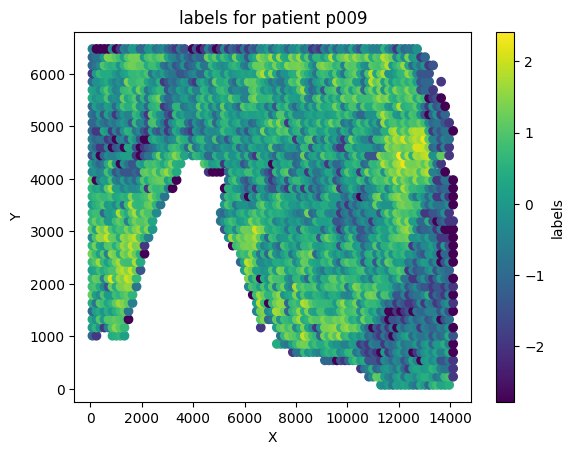

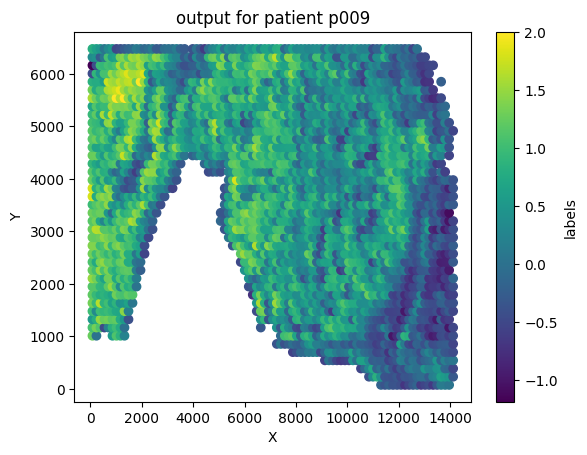

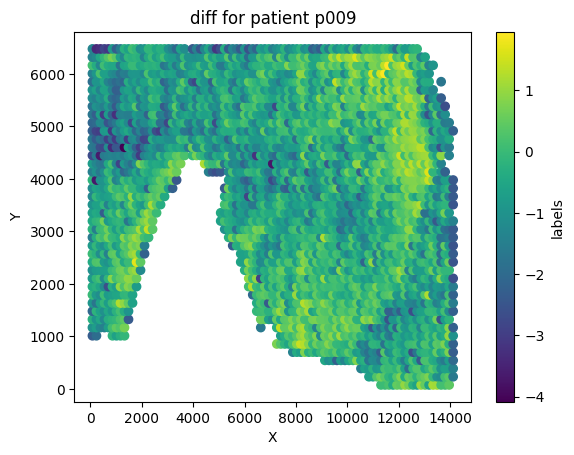

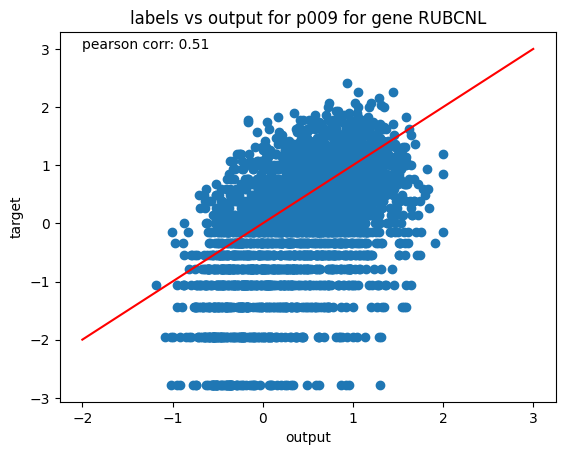

mean diff:  0.4314 , mean out:  0.4322 , mean labels:  0.0008
std diff:  0.4137 , std out:  0.5861 , std labels:  0.9998
pearson corr: 0.51
----------------------------------------
generating results...
../Training_Data/p013/Preprocessed_STDataset/slim_model_results.csv
0 / 920


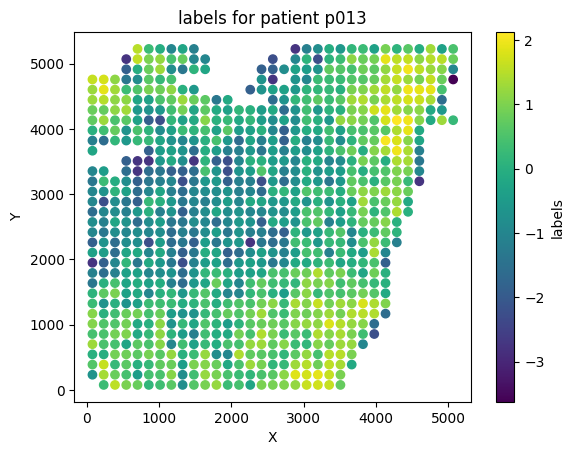

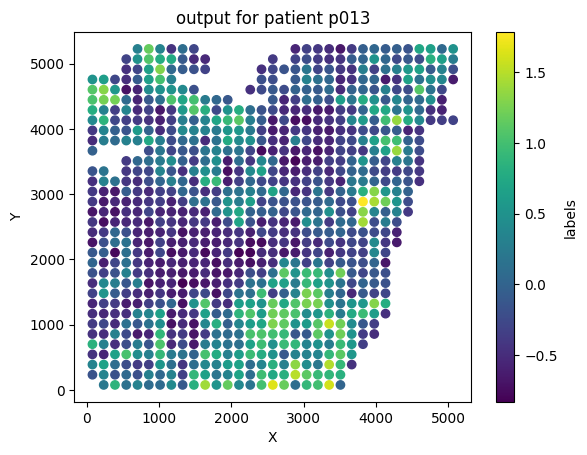

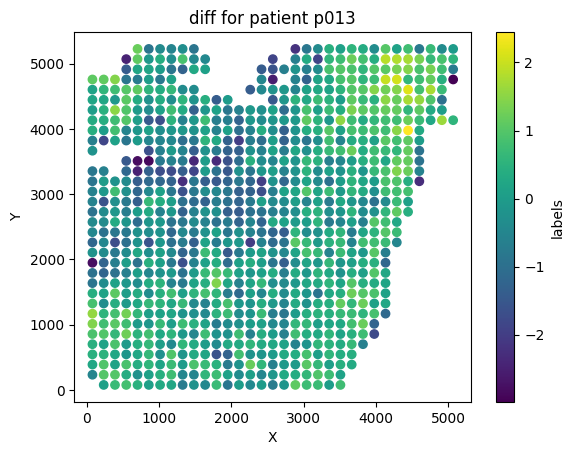

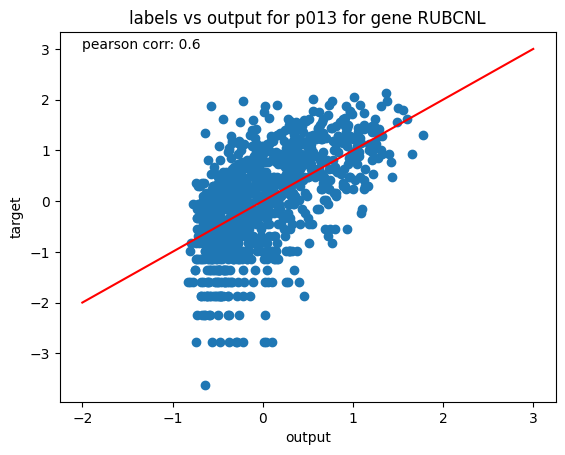

mean diff:  0.0153 , mean out:  0.0162 , mean labels:  0.0010
std diff:  0.4520 , std out:  0.5416 , std labels:  0.9937
pearson corr: 0.6
----------------------------------------


In [24]:
import os
data_dir = "../Training_Data/"
#patients = [os.path.basename(f) for f in os.scandir(data_dir) if f.is_dir()]
patients = ["p009", "p013"]
for patient in patients:
    if patient == "p008":
        continue
    process_and_plot_patient(old_model.to(device), device, criterion, data_dir, patient, "RUBCNL", results_filename = "slim_model_results.csv")